# Immgen PRJNA392905 - ATAC-Seq downsampling


In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import pandas as pd
import seaborn as sns
from IPython.display import display

sns.set_style("whitegrid")
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
from tqdm.auto import tqdm
import tempfile
import re
from itertools import product

In [25]:
PATH = os.path.expanduser('~/data/2023_Immgen_downsample')
CELLS = ['Monocyte']
! mkdir {PATH}/pics

In [26]:
def bedl(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return tf[2] - tf[1]
    except:
        return np.zeros(0)  # Empty file


def lines(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return len(tf)
    except:
        return 0  # Empty file

def d(a, b):
    return a / b if b != 0 else 0

def sorted_file(file):
    ts = tempfile.mktemp()
    !cat {file} | sort -k1,1 -k2,2n > {ts}
    return ts

def last_col(file):
    try:
        cols = len(pd.read_csv(file, sep='\t', nrows=1, header=None).columns)
        return pd.read_csv(file, sep='\t', header=None, usecols=[cols - 1])[cols - 1]
    except:
        return np.zeros(0)  # Empty file

In [42]:
def load_peaks_fdr(path, suffix, fdrs):
    df_fdr = pd.DataFrame(columns=['file', 'cell', 'srr', 'fdr', 'peaks', 'avlength'],
                          dtype=object)
    if not os.path.exists(path):
        return df_fdr
    for f in tqdm(os.listdir(path)):
        if suffix not in f:
            continue
        fdr = next((fdr for fdr in fdrs if fdr in f), None)
        cell = next((cc for cc in CELLS if cc in f), None)
        srr = re.sub('_.*', '', f)
        if fdr and cell and srr:
            peaks_path = os.path.join(path, f)
            ps, ls = lines(peaks_path), bedl(peaks_path)
            avls = 0 if ps == 0 else sum(ls) / ps
            df_fdr.loc[len(df_fdr)] = (peaks_path, cell, srr, fdr, ps, avls)
    return df_fdr

In [43]:
def load_peaks(path):
    df_fdr_macs2 = load_peaks_fdr(os.path.join(path, 'macs2'), '.narrowPeak', ['0.05'])
    df_fdr_macs2['tool'] = 'MACS2'
    print('MACS2', len(df_fdr_macs2))

    df_fdr_macs2broad = load_peaks_fdr(os.path.join(path, 'macs2'), '.broadPeak', ['0.1'])
    df_fdr_macs2broad['tool'] = 'MACS2 broad'
    print('MACS2 broad', len(df_fdr_macs2broad))

    df_fdr_sicer = load_peaks_fdr(os.path.join(path, 'sicer'), 'scoreisland', [''])
    df_fdr_sicer['tool'] = 'SICER'
    print('SICER', len(df_fdr_sicer))
    #
    df_fdr_span = load_peaks_fdr(os.path.join(path, 'span'), '.peak', ['0.05'])
    df_fdr_span['tool'] = 'SPAN'
    print('SPAN', len(df_fdr_span))

    return pd.concat([df_fdr_macs2, df_fdr_macs2broad, df_fdr_sicer, df_fdr_span]).reset_index(drop=True)

In [53]:
df_fdr_peaks_noise = load_peaks(PATH)
df_fdr_peaks_noise['quality'] = 0
for mln in [15, 10, 5, 2, 1, 0.5, 0.2, 0.1]:
    df_fdr_peaks_noise.loc[[f'_{mln}mln' in file for file in df_fdr_peaks_noise['file']], 'quality'] = mln
df_fdr_peaks_noise.sample(5)

  0%|          | 0/87 [00:00<?, ?it/s]

MACS2 24


  0%|          | 0/87 [00:00<?, ?it/s]

MACS2 broad 0


  0%|          | 0/24 [00:00<?, ?it/s]

SICER 0


  0%|          | 0/27 [00:00<?, ?it/s]

SPAN 24


,file,cell,srr,fdr,peaks,avlength,tool,quality
17,/home/jetbrains/data/2023_Immgen_downsample/ma...,Monocyte,SRR5799492,0.05,258,365.798450,MACS2,1.0
29,/home/jetbrains/data/2023_Immgen_downsample/sp...,Monocyte,SRR5799491,0.05,4116,413.910593,SPAN,0.5
37,/home/jetbrains/data/2023_Immgen_downsample/sp...,Monocyte,SRR5799492,0.05,18532,361.908105,SPAN,10.0
6,/home/jetbrains/data/2023_Immgen_downsample/ma...,Monocyte,SRR5799493,0.05,37740,181.239905,MACS2,10.0
5,/home/jetbrains/data/2023_Immgen_downsample/ma...,Monocyte,SRR5799492,0.05,3,236.333333,MACS2,0.2


In [54]:
TOOLS = ['MACS2', 'SPAN']
palette = plt.cm.get_cmap('tab10')
TOOLS_PALETTE = {t: palette(i) for i, t in enumerate(TOOLS)}

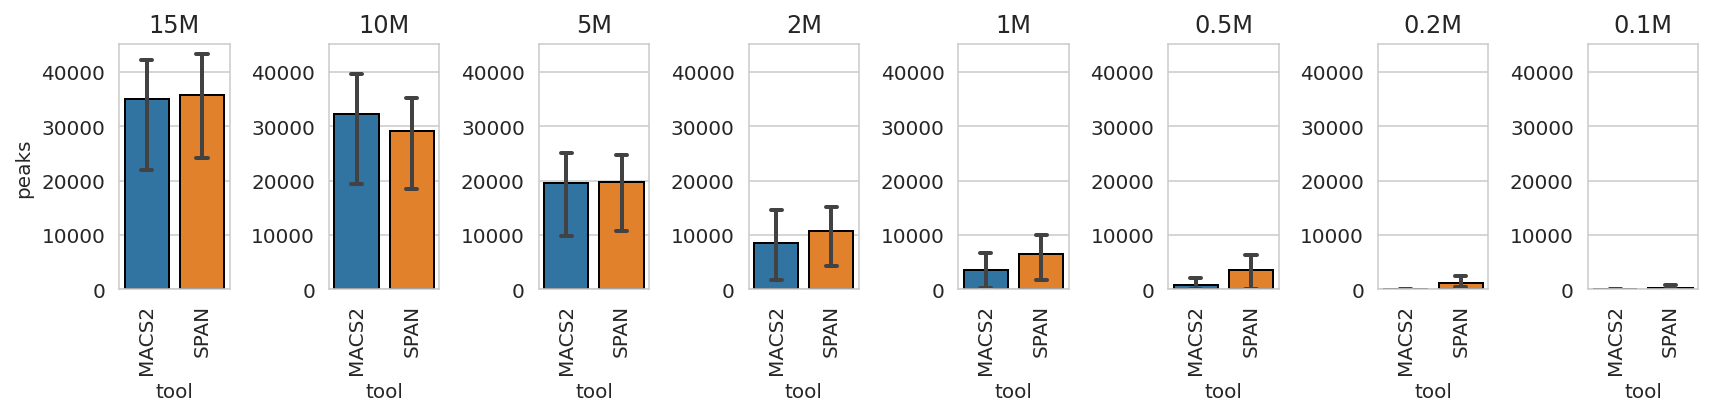

In [68]:
plt.figure(figsize=(12, 3))
axs = [plt.subplot(1, 8, i + 1) for i in range(8)]

for i, mln in enumerate([15, 10, 5, 2, 1, 0.5, 0.2, 0.1]):
    ax = axs[i]
    g_results = sns.barplot(data=df_fdr_peaks_noise[df_fdr_peaks_noise['quality']==mln],
                            x='tool', y='peaks', ax=ax,
                            capsize=.2, errwidth=2, edgecolor="black",
                            palette=TOOLS_PALETTE,
                            order=['MACS2', 'SPAN'])
    ax.set_ylim(0, 45_000)
    if i > 0:
        ax.set_ylabel(None)
    ax.xaxis.set_tick_params(rotation=90)
    ax.title.set_text(f'{mln}M')
plt.tight_layout()
plt.savefig(f'{PATH}/pics/peaks.pdf', bbox_inches='tight', dpi=300)
plt.show()

# Jaccard vs original peaks

In [62]:
import tempfile
from itertools import product

mln_bench_df = pd.DataFrame(
    columns=['cell', 'name', 'full_peaks', 'full_peaks_len',
             'quality', 'mln_peaks', 'mln_peaks_len',
             'full_overlap', 'mln_overlap',
             'overlap_len'],
    dtype=object
)

tf = tempfile.mktemp()

for c, tool, srr in tqdm(product(CELLS, TOOLS, df_fdr_peaks_noise['srr'].unique())):
    t = df_fdr_peaks_noise[(df_fdr_peaks_noise['tool'] == tool) &
                           (df_fdr_peaks_noise['cell'] == c) &
                           (df_fdr_peaks_noise['srr'] == srr) &
                           (df_fdr_peaks_noise['quality'] == 15)]
    if len(t) == 0:
        continue
    print(c, tool, srr)
    full_file = sorted_file(t['file'].values[0])
    full_peaks = lines(full_file)
    full_peaks_len = int(bedl(full_file).sum())
    for mln in [10, 5, 2, 1, 0.5, 0.2, 0.1]:
        t = df_fdr_peaks_noise[(df_fdr_peaks_noise['tool'] == tool) &
                               (df_fdr_peaks_noise['cell'] == c) &
                               (df_fdr_peaks_noise['srr'] == srr) &
                               (df_fdr_peaks_noise['quality'] == mln)]
        if len(t) == 0:
            continue
        mln_file = sorted_file(t['file'].values[0])
        mln_peaks = lines(mln_file)
        mln_peaks_len = int(bedl(mln_file).sum())
        !bedtools intersect -a {full_file} -b {mln_file} -wa -u > {tf}
        full_peaks_overlap = lines(tf)
        !bedtools intersect -b {full_file} -a {mln_file} -wa -u > {tf}
        mln_peaks_overlap = lines(tf)
        !bedtools intersect -a {full_file} -b {mln_file} -wo > {tf}
        overlap_len = int(last_col(tf).sum())
        mln_bench_df.loc[len(mln_bench_df)] = \
            (c, tool,
             full_peaks, full_peaks_len,
             mln, mln_peaks, mln_peaks_len,
             full_peaks_overlap, mln_peaks_overlap,
             overlap_len)

display(mln_bench_df.sample())

0it [00:00, ?it/s]

Monocyte MACS2 SRR5799492
Monocyte MACS2 SRR5799491
Monocyte MACS2 SRR5799493
Monocyte SPAN SRR5799492
Monocyte SPAN SRR5799491
Monocyte SPAN SRR5799493


,cell,name,full_peaks,full_peaks_len,quality,mln_peaks,mln_peaks_len,full_overlap,mln_overlap,overlap_len
26,Monocyte,SPAN,24123,8818196,0.2,16,15204,14,16,15168


In [63]:
mln_bench_df['precision'] = [d(a, b) for a, b in zip(mln_bench_df['mln_overlap'], mln_bench_df['mln_peaks'])]
mln_bench_df['sensitivity'] = [d(a, b) for a, b in zip(mln_bench_df['full_overlap'], mln_bench_df['full_peaks'])]
mln_bench_df['f1'] = [d(2, d(1, s + 1e-10) + d(1, p + 1e-10))
                      for s, p in zip(mln_bench_df['sensitivity'], mln_bench_df['precision'])]

mln_bench_df['precision_len'] = [d(a, b) for a, b in zip(mln_bench_df['overlap_len'], mln_bench_df['mln_peaks_len'])]
mln_bench_df['sensitivity_len'] = [d(a, b) for a, b in zip(mln_bench_df['overlap_len'], mln_bench_df['full_peaks_len'])]
mln_bench_df['f1_len'] = [d(2, d(1, s + 1e-10) + d(1, p + 1e-10))
                          for s, p in zip(mln_bench_df['sensitivity_len'], mln_bench_df['precision_len'])]

mln_bench_df['jaccard'] = [
    d(o, p + g -o)
    for p, g, o in zip(mln_bench_df['full_peaks_len'], mln_bench_df['mln_peaks_len'], mln_bench_df['overlap_len'])
]
mln_bench_df.sample(1)

,cell,name,full_peaks,full_peaks_len,quality,mln_peaks,mln_peaks_len,full_overlap,mln_overlap,overlap_len,precision,sensitivity,f1,precision_len,sensitivity_len,f1_len,jaccard
40,Monocyte,SPAN,39652,18954122,0.2,2561,856562,2535,2551,823980,0.996095,0.063931,0.120151,0.961962,0.043472,0.083185,0.043398


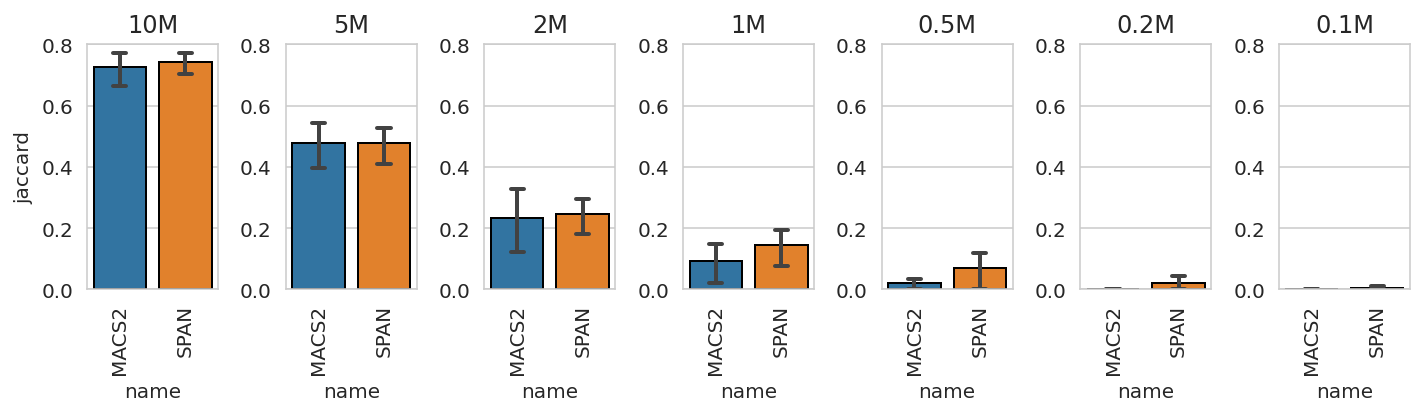

In [67]:
plt.figure(figsize=(10, 3))
axs = [plt.subplot(1, 7, i + 1) for i in range(7)]
for i, mln in enumerate([10, 5, 2, 1, 0.5, 0.2, 0.1]):
    ax = axs[i]
    g_results = sns.barplot(data=mln_bench_df[mln_bench_df['quality']==mln],
                            x='name', y='jaccard', ax=ax,
                            capsize=.2, errwidth=2, edgecolor="black",
                            palette=TOOLS_PALETTE,
                            order=['MACS2', 'SPAN'])
    ax.title.set_text(f'{mln}M')
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_ylim([0, 0.8])
    if i > 0:
        ax.set_ylabel(None)
plt.tight_layout()
plt.savefig(f'{PATH}/pics/jaccard.pdf', bbox_inches='tight', dpi=300)
plt.show()

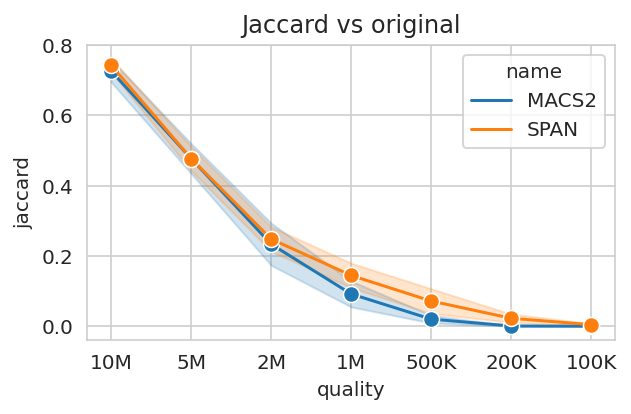

In [66]:
mln_bench_df['q'] = 0
for i, mln in enumerate([10, 5, 2, 1, 0.5, 0.2, 0.1]):
    mln_bench_df.loc[mln_bench_df['quality'] == mln, 'q'] = i

plt.figure(figsize=(4.5, 3))
g_results = sns.lineplot(data=mln_bench_df,
                         x='q', y='jaccard', hue='name',
                         hue_order=['MACS2', 'SPAN'],
                         palette=TOOLS_PALETTE,
                         errorbar='se', marker='o', markersize=8)
g_results.axes.set_xticks(range(7), minor=False)
g_results.axes.set_xticklabels(['10M', '5M', '2M', '1M', '500K', '200K', '100K'])
g_results.axes.set_xlabel('quality')
g_results.axes.title.set_text(f'Jaccard vs original')
# g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(f'{PATH}/pics/jaccard2.pdf', bbox_inches='tight', dpi=300)
plt.show()